<a href="https://colab.research.google.com/github/souravs17031999/Retinal_blindness_detection_Pytorch/blob/master/Single_test_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2
# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score
import time
from tqdm import tqdm_notebook



In [2]:

!pip install -q kagglehub

from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ravirajtekale123","key":"f223ee6a2cbd2e80e4f0f2e8ba6f80b6"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
import kagglehub

# This will download the dataset to the default kagglehub cache location
path = kagglehub.dataset_download("mariaherrerot/aptos2019")

print("Path to dataset files:", path)


100%|██████████| 8.01G/8.01G [01:17<00:00, 111MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3


In [5]:
print(os.listdir(path))

['test.csv', 'train_images', 'train_1.csv', 'valid.csv', 'test_images', 'val_images']


In [6]:
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '../input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = cv2.imread(img_path)  # if getting error, use PIL to load the image here.
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [23]:
from PIL import Image
import cv2

class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir='../input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name + '.png')

        # Load image using cv2
        image = cv2.imread(img_path)
        # Convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Convert numpy array to PIL Image
        image = Image.fromarray(image)

        if self.transform is not None:
            image = self.transform(image)

        return image, label


In [25]:
test_csv = pd.read_csv(os.path.join(path, "test.csv"))


In [26]:
test_path = os.path.join(path, "test_images", "test_images")

In [27]:
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    #torchvision.transforms.ColorJitter(brightness=2, contrast=2),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [28]:
test_csv['diagnosis'] = -1


In [29]:
test_data = CreateDataset(df_data=test_csv, data_dir=test_path, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [30]:
def round_off_preds(preds, coef=[0.5, 1.5, 2.5, 3.5]):
    for i, pred in enumerate(preds):
            if pred < coef[0]:
                preds[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                preds[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                preds[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                preds[i] = 3
            else:
                preds[i] = 4
    return preds

In [31]:
def predict(testloader):
    '''Function used to make predictions on the test set'''
    model.eval()
    preds = []
    for batch_i, (data, target) in enumerate(testloader):
        data, target = data.cuda(), target.cuda()
        output = model(data)
        pr = output.detach().cpu().numpy()
        for i in pr:
            preds.append(i.item())

    return preds

In [32]:
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(pretrained=False)

num_ftrs = model.fc.in_features
out_ftrs = 5

model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device);

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [34]:
# to unfreeze more layers
for name,child in model.named_children():
  if name in ['layer2','layer3','layer4','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

conv1is frozen
bn1is frozen
reluis frozen
maxpoolis frozen
layer1is frozen
layer2is unfrozen
layer3is unfrozen
layer4is unfrozen
avgpoolis frozen
fcis unfrozen


In [35]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.000001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [36]:
test_dir = os.path.join(path, "test_images", "test_images")

In [37]:
with torch.no_grad():
    model.eval()
    p_labels = []
    img_ids = []
    i = 0
    for inputs, labels in test_loader:
        i += 1
        if i % 10 == 0:
            print(f'{i} pass step')
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        p_labels.append(preds)
    # getting ids of file images

In [38]:
p_labels

[tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1,

In [39]:
pred_labels = []
for l in p_labels:
    for l1 in l:
        pred_labels.append(l1.item())

In [41]:

sample_sub = pd.read_csv(os.path.join(path, "valid.csv"))

In [42]:
sample_sub.diagnosis = pred_labels


In [43]:
sample_sub.head

<bound method NDFrame.head of           id_code  diagnosis
0    000c1434d8d7          1
1    001639a390f0          1
2    0024cdab0c1e          1
3    002c21358ce6          1
4    005b95c28852          1
..            ...        ...
361  1a90fad9ffa2          1
362  1ab3f1c71a5f          1
363  1ab8d3431ffc          1
364  1ade1e949383          1
365  1ae3c58759fb          1

[366 rows x 2 columns]>

In [44]:
sample_sub.to_csv('submission.csv', index=False)

In [45]:
def test_with_single_image(model, file, transform, classes):

    file = Image.open(file).convert('RGB')

    img = transform(file).unsqueeze(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        out = model(img.to(device))
        ps = torch.exp(out)
        top_p, top_class = ps.topk(1, dim=1)
        value = top_class.item()
        print("Value:", value)
        print(classes[value])
        plt.imshow(np.array(file))
        plt.show()

In [46]:
import random

test_dir = path
# take random folder first
folders = os.listdir(test_dir)
num = 2
path = test_dir+"/"+folders[num]
print(path)
# save label
label = folders[num]

# now take random file
files = os.listdir(path)
num = random.randint(0, len(files)-1)
name = path + "/" + files[num]
print('Path: ', name)

/root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3/train_1.csv


NotADirectoryError: [Errno 20] Not a directory: '/root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3/train_1.csv'

In [47]:
import os
import random

# Root directory of your dataset (adjust this if needed)
root_dir = "/root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3"

# The actual images are inside this nested folder:
image_dir = os.path.join(root_dir, "train_images", "train_images")

# List all files inside the image directory
files = os.listdir(image_dir)
print(f"Total files found: {len(files)}")
print(f"First 5 files: {files[:5]}")

# Pick a random image file
random_idx = random.randint(0, len(files) - 1)
random_file = files[random_idx]
random_file_path = os.path.join(image_dir, random_file)

print("Random image file path:", random_file_path)


Total files found: 2930
First 5 files: ['7356dd08b0ae.png', 'a12ca80bb8c7.png', 'a95d9d61ddd4.png', '82f2784ead76.png', '90a9a41eec6d.png']
Random image file path: /root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3/train_images/train_images/c0a117de7d0a.png


Value: 1
Mild


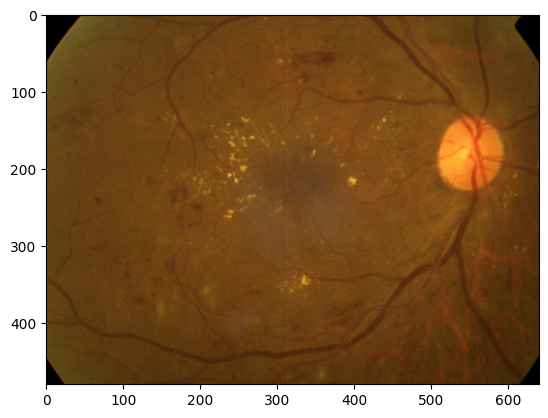

In [51]:
# Suppose this was your random image path:
name = "/root/.cache/kagglehub/datasets/mariaherrerot/aptos2019/versions/3/train_images/train_images/7356dd08b0ae.png"

# Now call your test function
classes = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
test_with_single_image(model, name, test_transforms, classes)
